In [241]:
import pandas as pd
from math import*
import re
import logging
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
import seaborn as sns
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity

In [242]:
#initialisation
n_most_similar = 1
n_features_title = 25  #25
n_features_content = 30  #30
n_features_tags = 25   #25
n_features_total = 40   


df = None #dataframe
df_article_vectors = None #vectorized articles
X = None
X_title = None  #vectorized title
X_content = None  #vectorized content
X_tags = None #vectorized tags


# DATA LOADING + CLEANING 

In [278]:
initial = pd.read_csv('/home/pallavi/SEM_5/DA/PROJECT/dataset/articles.csv', encoding='utf-8')
initial.head()

,Unnamed: 0,title,link,content_html,content_text,tags
0,1,Automating routine with a hackathon,/automating-google-tag-manager-using-a-hackath...,"\n <div class=""kg-card-markdown""><p...","In today's hectic world, it's valuable to look...",[]
1,2,Making Work A Work-Out: AR At The Office,/making-work-a-work-out-ar-at-the-office/,"\n <div class=""kg-card-markdown""><p...","This post concerns Greenhouse Group Labs, an i...","['Augmented Reality', 'Health', 'Work', 'Weara..."
2,3,Creating a lightweight game using PixiJs - part 1,/creating-a-lightweight-game-using-pixijs/,"\n <div class=""kg-card-markdown""><p...",We live in a world in which advertisement is m...,"['JavaScript', 'PIXI', 'PixiJs', 'canvas', 'ga..."
3,4,Can AR reach Generation Z where normal adverti...,/can-ar-reach-generation-z-where-normal-advert...,"\n <div class=""kg-card-markdown""><p...",With an average attention span of 12 seconds a...,"['Snapchat', 'Facebook', 'Augmented Reality', ..."
4,5,The Rise & All of Social AR,/ar-f8-update/,"\n <div class=""kg-card-markdown""><p...","In the new age of AR, they way we connect with...","['Facebook', 'Augmented Reality', 'Social adve..."


In [243]:
# removing unnecessary columns
df = pd.read_csv('/home/pallavi/SEM_5/DA/PROJECT/dataset/articles.csv', encoding='utf-8') # Load articles in a DataFrame
df = df[['title', 'content_text', 'tags']]  # Slice to remove redundant columns
print("size of the dataset : ", len(df))
df

size of the dataset :  186


,title,content_text,tags
0,Automating routine with a hackathon,"In today's hectic world, it's valuable to look...",[]
1,Making Work A Work-Out: AR At The Office,"This post concerns Greenhouse Group Labs, an i...","['Augmented Reality', 'Health', 'Work', 'Weara..."
2,Creating a lightweight game using PixiJs - part 1,We live in a world in which advertisement is m...,"['JavaScript', 'PIXI', 'PixiJs', 'canvas', 'ga..."
3,Can AR reach Generation Z where normal adverti...,With an average attention span of 12 seconds a...,"['Snapchat', 'Facebook', 'Augmented Reality', ..."
4,The Rise & All of Social AR,"In the new age of AR, they way we connect with...","['Facebook', 'Augmented Reality', 'Social adve..."
5,Jumping the highly promising AR train!,You might have heard of it. You might have use...,"['Augmented Reality', 'consumer experience', '..."
6,AI meets graphic design,"Over the last decade, the transition from TV t...","['Data Science', 'Artificial Intelligence', 'd..."
7,Using the Google Analytics customTask to play ...,Have you ever wondered: wouldn't it be nice if...,"['google analytics', 'custom task', 'super mar..."
8,⚡AMPing up? A few things to consider.,"A few weeks ago, I attended AMPConf 2018 in Am...","['tech', 'html5', 'user experience']"
9,Multi-level blocking rules in GTM,Google Tag Manager has many great features whe...,"['google tag manager', 'blocking rules', 'trig..."


In [244]:
# assigning tags to each article + cleaning
temp = df['tags']      
temp = temp.str.lower()
temp = temp.str.split(",", n = 1, expand = True)
temp = temp[0]
temp = temp.str.replace("[","")
temp = temp.str.replace("]","")
temp = temp.str.replace("'","")
df['first_tag'] = temp


for i in range(0, len(df["first_tag"])):
    if df["first_tag"][i] == '':
        df["first_tag"][i] = 'none'
df

,title,content_text,tags,first_tag
0,Automating routine with a hackathon,"In today's hectic world, it's valuable to look...",[],none
1,Making Work A Work-Out: AR At The Office,"This post concerns Greenhouse Group Labs, an i...","['Augmented Reality', 'Health', 'Work', 'Weara...",augmented reality
2,Creating a lightweight game using PixiJs - part 1,We live in a world in which advertisement is m...,"['JavaScript', 'PIXI', 'PixiJs', 'canvas', 'ga...",javascript
3,Can AR reach Generation Z where normal adverti...,With an average attention span of 12 seconds a...,"['Snapchat', 'Facebook', 'Augmented Reality', ...",snapchat
4,The Rise & All of Social AR,"In the new age of AR, they way we connect with...","['Facebook', 'Augmented Reality', 'Social adve...",facebook
5,Jumping the highly promising AR train!,You might have heard of it. You might have use...,"['Augmented Reality', 'consumer experience', '...",augmented reality
6,AI meets graphic design,"Over the last decade, the transition from TV t...","['Data Science', 'Artificial Intelligence', 'd...",data science
7,Using the Google Analytics customTask to play ...,Have you ever wondered: wouldn't it be nice if...,"['google analytics', 'custom task', 'super mar...",google analytics
8,⚡AMPing up? A few things to consider.,"A few weeks ago, I attended AMPConf 2018 in Am...","['tech', 'html5', 'user experience']",tech
9,Multi-level blocking rules in GTM,Google Tag Manager has many great features whe...,"['google tag manager', 'blocking rules', 'trig...",google tag manager


# CONVERTING ARTICLES TO NUMERIC FORMAT

vectorize data

Vectorize training data, i.e. perform a 3-gram feature extraction and selection method using FP, Chi or RP

return: Result is a numeric and weighted feature vector notation for each article

In [245]:
def vectorize_articles():
        global X
        # Vectorize article
        vectorize_title()    # Add title as dummies
        vectorize_content()  # Add content as dummies
        vectorize_tags()     # Add title as dummies
       #Concatenate all article vectors, i.e. title, content, tags and author
        article_metrics = (X_title, X_content, X_tags)
        X = np.concatenate(article_metrics, axis=1)

In [246]:
# vectorizer function : uses the concept of BOW(bag of words) along with n-gram(to preserve some ordering) 
def get_vectorizer(ngram_range=(1, 3), min_df=2, max_df=1.0):
    
        vectorizer = CountVectorizer(ngram_range=ngram_range,
                                     tokenizer=tokenize,
                                     min_df=min_df,
                                     max_df=max_df,
                                     binary=True,
                                     stop_words='english')
        return vectorizer

In [247]:
# tokenization function to be passed as the tokenizer to the CountVectorizer function
# removes white spaces, stop words and stems the document
def tokenize(text):
    tokens = nltk.WhitespaceTokenizer().tokenize(text)
    tokens = list(set(re.sub("[^a-zA-Z\']", "", token) for token in tokens))
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    tokens = list(set(re.sub("[^a-zA-Z]", "", token) for token in tokens))
    stems = []
    stemmer = SnowballStemmer("english")
    for token in tokens:
        token = stemmer.stem(token)
        if token != "":
            stems.append(token)
    return stems
    

In [248]:
# vectorize title
def vectorize_title():
    global X_title
    vectorizer = get_vectorizer(ngram_range=(1, 2),min_df=2)
    X_title = vectorizer.fit_transform(df['title'])
    X_title = X_title.toarray()
    X_title = np.array(X_title, dtype=float)
    X_title = reduce_dimensionality(X_title, n_features=n_features_title)

In [249]:
# vectorize content
def vectorize_content():
    global X_content
    vectorizer = get_vectorizer(ngram_range=(1, 1),min_df=4,max_df=0.3)
    X_content = vectorizer.fit_transform(df['content_text'])
    X_content = X_content.toarray()
    X_content = np.array(X_content, dtype=float)
    X_content = reduce_dimensionality(X_content, n_features=n_features_content)


In [250]:
# vectorize tags
def vectorize_tags():
    global X_tags
    n_tags = 0
    df_tags = pd.DataFrame(index=df.index)
    # df_tags
    df_tags.columns
    for index, row in df.iterrows():
            if row['tags'] != '':
                values = row['tags'].split(", ")
                for value in values:
                    if value not in df_tags.columns:
                        df_tags[value] = 0.0
                        n_tags += 1
                    df_tags.ix[index, value] = 1.0
    X_tags = np.array(df_tags, dtype=float)
    X_tags = reduce_dimensionality(X_tags, n_features=n_features_tags)
    
# df_tags

In [251]:
# Reduce the dimensionality of the vectorized articles.
def reduce_dimensionality_articles():
        global X
        X = reduce_dimensionality(X, n_features=n_features_total)
    

In [252]:
# Apply PCA or SVD to reduce dimension to n_features.
def reduce_dimensionality(X, n_features):
        # Initialize reduction method: PCA or SVD
        # reducer = PCA(n_components=n_features)
        reducer = TruncatedSVD(n_components=n_features)
        # Fit and transform data to n_features-dimensional space
        reducer.fit(X)
        X = reducer.transform(X)
        return X

In [253]:
vectorize_articles()
reduce_dimensionality_articles()

/usr/local/lib/python3.5/dist-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.
  sorted(inconsistent))
/usr/local/lib/python3.5/dist-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the st

In [254]:
X[0]

array([ 5.15340364, -0.91730922,  0.68768931, -0.50749177, -1.53161733,
       -1.03888223, -1.52678057, -0.69208076,  2.30659672,  2.02493261,
       -0.22670885,  1.11993548,  0.13335943,  1.04285644,  0.38363845,
       -0.83011516, -0.44882806, -0.14060357, -0.66204939,  0.1607645 ,
        0.57284083,  0.63305639, -0.56271604, -1.69921155,  0.6086561 ,
        1.69240566, -1.68526897, -1.9279175 , -1.86118761,  2.34249664,
       -0.57298043, -0.18707153, -0.30896014, -0.04157248,  0.16019005,
       -0.07603406,  0.00991629,  0.15412276,  0.38614889, -0.36456003])

In [255]:
def prepare_dataframe(X):
        global n_most_similar
        df_article_vectors = pd.DataFrame(None)
        df_article_vectors['first_tag'] = df['first_tag']
        df_article_vectors['title'] = df['title']
        df_article_vectors['numbers'] = range(0, len(df_article_vectors))
        df_article_vectors['coordinates'] = df_article_vectors['numbers'].apply(lambda index: X[index, :])
        del df_article_vectors['numbers']
        # Initialize dataframe by appending new columns to store the titles of the n most similar articles
        for i in range(0, n_most_similar):
            df_article_vectors['most_similar_'+str(i+1)] = ""
        return df_article_vectors

In [256]:
def visualize_data():
        global X
        # Reduce dimensionality to 2 features for visualization purposes
        X_visualization = reduce_dimensionality(X, n_features=2)
        df = prepare_dataframe(X_visualization)
        # Set X and Y coordinate for each articles
        df['X coordinate'] = df['coordinates'].apply(lambda x: x[0])
        df['Y coordinate'] = df['coordinates'].apply(lambda x: x[1])
        # Create a list of markers, each tag has its own marker
        n_tags_first = len(df['first_tag'].unique())
        markers_choice_list = ['o', 's', '^', '.', 'v', '<', '>', 'D']
        markers_list = [markers_choice_list[i % 8] for i in range(n_tags_first)]
        # Create scatter plot
        sns.lmplot("X coordinate",
                   "Y coordinate",
                   hue="first_tag",
                   data=df,
                   fit_reg=False,
                   markers=markers_list,
                   scatter_kws={"s": 150})
        # Adjust borders and add title
        sns.set(font_scale=1)
        sns.plt.title('Visualization of TMT articles in a 2-dimensional space')
        sns.plt.subplots_adjust(right=1, top=1, left=1, bottom=1)
        # Show plot
        sns.plt.show()

AttributeError: module 'seaborn' has no attribute 'plt'

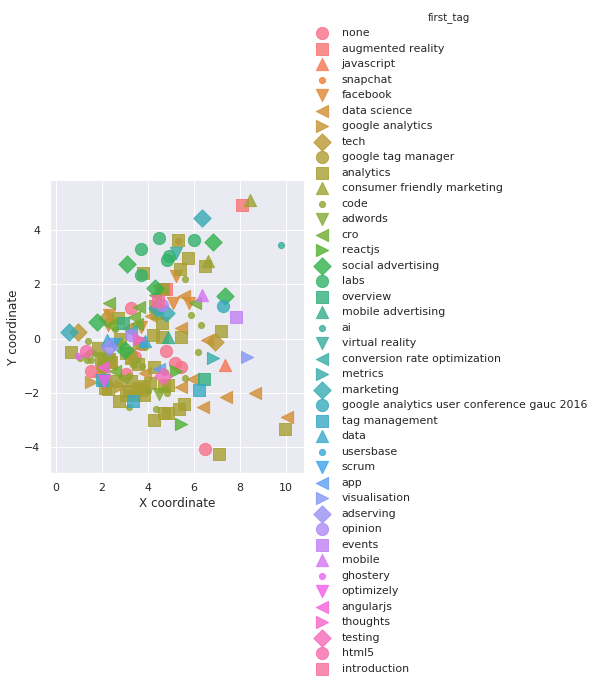

In [257]:
visualize_data()

# Finding similar articles for each article using Cosine similarity and Euclidean Distance.

similar articles using cosine similarity

In [258]:
sim = cosine_similarity(X)
print(sim[0])

[1.         0.38770553 0.29808416 0.32940977 0.3183424  0.25532137
 0.53044435 0.33253818 0.44477608 0.48790246 0.53670322 0.51899857
 0.59658573 0.44480794 0.41823412 0.32507678 0.68830031 0.48675053
 0.41589537 0.48193273 0.39820372 0.37219429 0.30180521 0.59125424
 0.47476521 0.32879632 0.42434697 0.52088457 0.45362637 0.64210813
 0.31809612 0.4002826  0.38411882 0.36045838 0.15836881 0.5835823
 0.52805764 0.29352282 0.43516436 0.19211657 0.27992804 0.30762304
 0.46782135 0.22617326 0.46716583 0.29584751 0.51085346 0.22392445
 0.3204724  0.42786825 0.11303406 0.50956207 0.22180639 0.40062698
 0.52401205 0.47601973 0.26403044 0.2416259  0.50100315 0.39258048
 0.58127706 0.4992898  0.28656093 0.27886493 0.27796021 0.27120896
 0.31605249 0.43615866 0.19808843 0.40858231 0.53950618 0.45818263
 0.50995983 0.33341023 0.29222373 0.29785364 0.25303722 0.41925205
 0.32890665 0.48848191 0.33895729 0.18651865 0.45512809 0.3007081
 0.37883294 0.23929875 0.32972911 0.27961269 0.46227234 0.328235

In [259]:
sim_doc = []
docx = 0
docy = 0
temp_sim = []

for x in sim:
    for y in x:
        if y > 0.5 and y:
            temp_sim.append(docy)
        docy = docy+1
    
    sim_doc.append(temp_sim)
    docy = 0
    temp_sim = []
                        
sim_doc

[[0,
  6,
  10,
  11,
  12,
  16,
  23,
  27,
  29,
  35,
  36,
  46,
  51,
  54,
  58,
  60,
  70,
  72,
  116,
  135,
  149,
  161,
  171,
  174],
 [1, 74, 75, 93, 98, 120],
 [2, 8, 35, 65, 77, 88, 124, 129, 135, 151, 160, 165, 169, 172],
 [3, 4, 5, 6, 42, 47, 50, 75, 76, 81, 84, 91, 100, 106, 170],
 [3, 4, 5, 20, 39, 46, 67, 75, 76, 89, 101, 106, 112, 149],
 [3, 4, 5, 6, 15, 30, 39, 56, 68, 75, 77, 78, 88, 98, 101, 105, 120, 158, 181],
 [0, 3, 5, 6, 20, 39, 44, 64, 78, 98, 130, 168, 177],
 [7,
  9,
  10,
  14,
  21,
  25,
  26,
  27,
  35,
  38,
  54,
  55,
  59,
  66,
  72,
  77,
  79,
  88,
  102,
  108,
  111,
  119,
  125,
  126,
  131,
  133,
  134,
  136,
  137,
  142,
  143,
  144,
  145,
  146,
  150,
  155,
  163,
  164,
  165,
  166,
  174,
  175,
  178,
  180,
  181,
  183,
  184],
 [2, 8, 46, 65, 99, 101, 131, 135, 148, 149, 151, 160, 172, 176, 179, 182],
 [7,
  9,
  10,
  11,
  14,
  18,
  22,
  23,
  26,
  27,
  29,
  35,
  37,
  38,
  48,
  54,
  55,
  70,
  79,
  99,

In [273]:
df['Similar Documents using Cosine']=sim_doc #new dataframe with similar documents

Euclidean distance

In [261]:
from scipy.spatial import distance
euclidean = []

for a in range(0,len(X)):
    temp = []
    for b in range(0,len(X)):
        temp.append((distance.euclidean(X[a],X[b]),b))
    euclidean.append(temp)
euclidean[0]
# len(euclidean[0])
# len([1 for i in euclidean[0] if i<7])

[(0.0, 0),
 (14.818217514698878, 1),
 (13.421455329019444, 2),
 (10.29587197143379, 3),
 (9.438259389841615, 4),
 (9.951982051300165, 5),
 (8.415428536220507, 6),
 (8.190409179685782, 7),
 (10.818351882149106, 8),
 (7.423920449447919, 9),
 (7.12300410232803, 10),
 (7.312335816836546, 11),
 (7.506103860463931, 12),
 (14.14427660675897, 13),
 (7.6641648534632045, 14),
 (11.366498397663092, 15),
 (6.3332943847892915, 16),
 (12.245828627571822, 17),
 (8.278112677851775, 18),
 (7.518450986896899, 19),
 (8.08962448438827, 20),
 (11.155937310382798, 21),
 (8.399875819255096, 22),
 (7.110660687088155, 23),
 (7.546352877344112, 24),
 (8.241923415137416, 25),
 (7.640273737345917, 26),
 (7.225847132145574, 27),
 (8.896781378942551, 28),
 (6.700452135043434, 29),
 (12.693511456875457, 30),
 (8.759872707518198, 31),
 (8.01819862822535, 32),
 (9.894200118195798, 33),
 (14.977454853522492, 34),
 (7.321666477112316, 35),
 (8.213893988305921, 36),
 (8.391722300117973, 37),
 (8.434658869699488, 38),
 (1

In [262]:
for i in range(0,len(euclidean)):
    euclidean[i].sort()
euclidean[0]

sim_docs = []
for i in range(0,len(euclidean)):
    temp = []
    for j in range(0,len(euclidean)):
        if i==euclidean[i][j][1] :
            continue
        elif len(temp)==5 :
            break
        else:
            temp.append(euclidean[i][j][1])
    sim_docs.append(temp)
sim_docs           

[[16, 29, 149, 60, 23],
 [98, 75, 93, 74, 120],
 [35, 65, 88, 169, 160],
 [81, 75, 76, 84, 4],
 [76, 46, 106, 67, 75],
 [101, 98, 181, 88, 78],
 [20, 177, 44, 64, 152],
 [175, 14, 26, 180, 144],
 [160, 151, 149, 182, 131],
 [11, 174, 79, 180, 104],
 [29, 9, 11, 14, 180],
 [9, 29, 174, 155, 142],
 [103, 16, 29, 149, 117],
 [147, 94, 167, 148, 50],
 [26, 180, 174, 66, 9],
 [52, 25, 181, 28, 108],
 [29, 149, 24, 46, 183],
 [95, 72, 129, 118, 154],
 [27, 150, 146, 108, 164],
 [109, 66, 26, 14, 129],
 [37, 46, 84, 149, 9],
 [19, 126, 127, 113, 53],
 [25, 178, 165, 104, 156],
 [70, 137, 29, 31, 11],
 [140, 174, 162, 184, 77],
 [108, 178, 22, 143, 156],
 [14, 180, 109, 9, 66],
 [26, 9, 29, 14, 10],
 [25, 113, 148, 70, 16],
 [11, 9, 10, 140, 24],
 [15, 52, 69, 88, 123],
 [94, 86, 23, 55, 92],
 [129, 160, 145, 165, 60],
 [46, 25, 107, 118, 156],
 [105, 97, 181, 56, 50],
 [60, 88, 145, 183, 135],
 [44, 51, 16, 80, 149],
 [56, 79, 24, 176, 149],
 [137, 26, 7, 27, 125],
 [64, 63, 44, 98, 74],
 [14

In [274]:
df['Similar Documents using Euclidean']=sim_docs
df.head()

,title,content_text,tags,first_tag,Similar Documents using Cosine,Similar Documents using Euclidean
0,Automating routine with a hackathon,"In today's hectic world, it's valuable to look...",[],none,"[0, 6, 10, 11, 12, 16, 23, 27, 29, 35, 36, 46,...","[16, 29, 149, 60, 23]"
1,Making Work A Work-Out: AR At The Office,"This post concerns Greenhouse Group Labs, an i...","['Augmented Reality', 'Health', 'Work', 'Weara...",augmented reality,"[1, 74, 75, 93, 98, 120]","[98, 75, 93, 74, 120]"
2,Creating a lightweight game using PixiJs - part 1,We live in a world in which advertisement is m...,"['JavaScript', 'PIXI', 'PixiJs', 'canvas', 'ga...",javascript,"[2, 8, 35, 65, 77, 88, 124, 129, 135, 151, 160...","[35, 65, 88, 169, 160]"
3,Can AR reach Generation Z where normal adverti...,With an average attention span of 12 seconds a...,"['Snapchat', 'Facebook', 'Augmented Reality', ...",snapchat,"[3, 4, 5, 6, 42, 47, 50, 75, 76, 81, 84, 91, 1...","[81, 75, 76, 84, 4]"
4,The Rise & All of Social AR,"In the new age of AR, they way we connect with...","['Facebook', 'Augmented Reality', 'Social adve...",facebook,"[3, 4, 5, 20, 39, 46, 67, 75, 76, 89, 101, 106...","[76, 46, 106, 67, 75]"


# Recommendation and Testing Phase
displaying the articles similar to the given article

In [265]:
# following are the result for article 1 using euclidean distance

similar=df['Similar Documents using Euclidean']
def simarticles(op):
    o=[]
    for i in similar[op]:
        o.append(df['title'][i])
    return o

similar_euc=simarticles(1)
print('input article :', df['title'][1])
print('similar articles are : ')
for i in similar_euc:
    print(i)



input article : Making Work A Work-Out: AR At The Office
similar articles are : 
Virtual reality: connecting Unity to the CAVE
VIVA VR: Introduction to using Virtual Reality for marketing (part 1)
A GHG Labs concept: The first worldwide web loyalty system
GHG Labs: "The web loyalty system is ready to bring change to digital marketing"
Smart clothing makes it feel real


In [266]:
# following are the result for article 1 using cosine similarity

similar2=df['Similar Documents using Cosine']
def simarticles2(op):
    o=[]
    for i in similar2[op]:
        o.append(df['title'][i])
    return o
similar_cos=simarticles2(1)

print('input article :', df['title'][1])
print('similar articles are : ')
for i in similar_cos:
    print(i)


input article : Making Work A Work-Out: AR At The Office
similar articles are : 
Making Work A Work-Out: AR At The Office
GHG Labs: "The web loyalty system is ready to bring change to digital marketing"
VIVA VR: Introduction to using Virtual Reality for marketing (part 1)
A GHG Labs concept: The first worldwide web loyalty system
Virtual reality: connecting Unity to the CAVE
Smart clothing makes it feel real


['Augmented Reality', 'Health', 'Work', 'Wearables', 'Labs', 'AR Glasses']
['Augmented Reality', 'Health', 'Work', 'Wearables', 'Labs', 'AR Glasses']
['Labs', 'Adblocker']
['Virtual Reality', 'VR']
['Labs', 'Analytics', 'Adblocker']
['Labs', 'Code', 'VR', 'Virtual Reality', 'Cave']
['Code', 'Labs', 'Smart clothing']


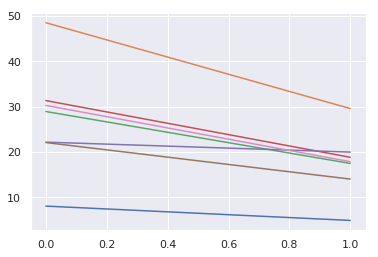

In [268]:
import matplotlib.pyplot as plt

temp = reduce_dimensionality(X, n_features=2)
s = df['Similar Documents using Cosine'][1]
tags = df['tags'][1]
print(tags)
plt.plot(test[1])

for i in s:
    stags = df['tags'][i]
    print(stags)
    plt.plot(6*test[i])


['Augmented Reality', 'Health', 'Work', 'Wearables', 'Labs', 'AR Glasses']
['Labs', 'Code', 'VR', 'Virtual Reality', 'Cave']
['Virtual Reality', 'VR']
['Labs', 'Analytics', 'Adblocker']
['Labs', 'Adblocker']
['Code', 'Labs', 'Smart clothing']


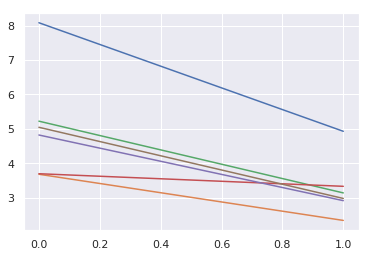

In [270]:
temp = reduce_dimensionality(X, n_features=2)
s = df['Similar Documents using Euclidean'][1]
tags = df['tags'][1]
print(tags)
plt.plot(test[1])

for i in s:
    stags = df['tags'][i]
    print(stags)
    plt.plot(test[i])

['Augmented Reality', 'consumer experience', 'Social advertising']
['Snapchat', 'Facebook', 'Augmented Reality', 'Social advertising', 'Generation Z']
['Facebook', 'Augmented Reality', 'Social advertising']
['Augmented Reality', 'consumer experience', 'Social advertising']
['Data Science', 'Artificial Intelligence', 'design']
['Code', 'viewability', 'Analytics']


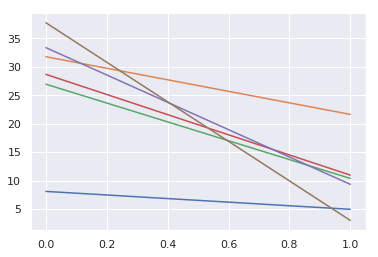

In [276]:
import matplotlib.pyplot as plt

temp = reduce_dimensionality(X, n_features=2)
s = df['Similar Documents using Cosine'][5]

tags = df['tags'][5]
print(tags)
plt.plot(test[1])

c=0
for i in s:
    stags = df['tags'][i]
    print(stags)
    plt.plot(6*test[i])
    c+=1
    if c==5:
        break

['Augmented Reality', 'consumer experience', 'Social advertising']
[]
['Labs', 'Code', 'VR', 'Virtual Reality', 'Cave']
['thoughts', 'Code']
[]
['Labs', 'Virtual Reality', 'VR']


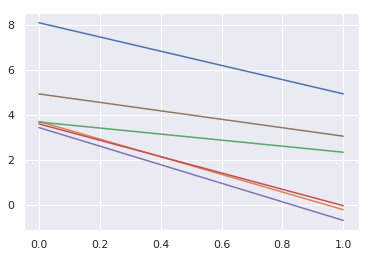

In [277]:
temp = reduce_dimensionality(X, n_features=2)
s = df['Similar Documents using Euclidean'][5]
tags = df['tags'][5]
print(tags)
plt.plot(test[1])

for i in s:
    stags = df['tags'][i]
    print(stags)
    plt.plot(test[i])